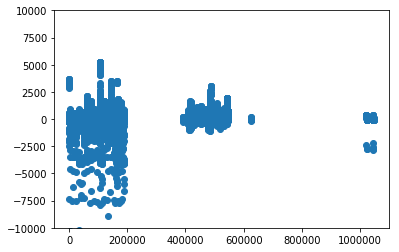

In [6]:
from math import sqrt
from numpy import concatenate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_squared_error


data_set = pd.read_csv('/Users/shenghaoisyummy/Capstone/feature_extraction_data_dummis_all.csv', index_col=0)
plt.scatter(data_set.index.values , data_set['arrv_late_time'])
plt.ylim(-10000, 10000)

plt.show()

In [19]:
def time_to_total_minutes(df):
    df['target_minitues'] = df['arrv_late_time']/60

time_to_total_minutes(data_set)
data_set['target_minitues']

1         -1.0
2         -1.0
3         -1.0
4         -2.0
5         -1.0
6         -1.0
7         -1.0
8         -1.0
9         -1.0
10        -2.0
11        -2.0
12        -1.0
13        -2.0
14        -2.0
15         0.0
16         0.0
17         0.0
18         0.0
19         0.0
20        -2.0
21        -2.0
22        -1.0
23        -1.0
24        -1.0
25        -1.0
26        -3.0
27        -2.0
28         0.0
29         0.0
30        -1.0
          ... 
1046741    0.0
1046742    0.0
1046743   -2.0
1046744   -1.0
1046745   -1.0
1046746    0.0
1046747   -1.0
1046748   -1.0
1046749    0.0
1046750    1.0
1046751    1.0
1046752    1.0
1046753    2.0
1046754    1.0
1046755    1.0
1046756    1.0
1046757    1.0
1046758    1.0
1047008    0.0
1047009    0.0
1047010    0.0
1047011    1.0
1047012    1.0
1047013    0.0
1047014   -1.0
1047015    0.0
1047016   -1.0
1047017   -1.0
1047018   -2.0
1047019   -2.0
Name: target_minitues, Length: 69197, dtype: float64

In [20]:
data_Y = data_set[['target_minitues']]
data_set.drop(['actual_station_arrv_time_hours','actual_station_arrv_time_minutes', 'arrv_late_time', 'dprt_late_time', 'actual_station_dprt_time_hours', 'actual_station_dprt_time_minutes', 'target_minitues'], axis=1, inplace=True)

In [21]:
data_X = VarianceThreshold(threshold=3).fit_transform(data_set)
data_X.shape

(69197, 88)

In [22]:
data_Y.values

array([[-1.],
       [-1.],
       [-1.],
       ...,
       [-1.],
       [-2.],
       [-2.]])

In [23]:
# make sure value as float
data_X_values = data_X
data_X_values = data_X_values.astype('float32')

data_Y_values = data_Y.values
data_Y_values = data_Y_values.astype('float32')
# normalization
scaler = MinMaxScaler(feature_range=(-1, 1))
data_X_values = scaler.fit_transform(data_X_values)
data_Y_values = scaler.fit_transform(data_Y_values)
# split train test
train_X, test_X, train_y, test_y = train_test_split(data_X_values, data_Y_values, test_size = 0.2, random_state = 4)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))



In [24]:
model = Sequential()

Train on 55357 samples, validate on 13840 samples
Epoch 1/50
 - 386s - loss: 0.0117 - val_loss: 0.0083
Epoch 2/50
 - 380s - loss: 0.0090 - val_loss: 0.0086
Epoch 3/50
 - 362s - loss: 0.0089 - val_loss: 0.0076
Epoch 4/50
 - 377s - loss: 0.0088 - val_loss: 0.0071
Epoch 5/50
 - 391s - loss: 0.0088 - val_loss: 0.0078
Epoch 6/50
 - 344s - loss: 0.0088 - val_loss: 0.0073
Epoch 7/50
 - 379s - loss: 0.0087 - val_loss: 0.0084
Epoch 8/50
 - 381s - loss: 0.0087 - val_loss: 0.0076
Epoch 9/50
 - 379s - loss: 0.0086 - val_loss: 0.0071
Epoch 10/50
 - 351s - loss: 0.0087 - val_loss: 0.0085
Epoch 11/50
 - 384s - loss: 0.0087 - val_loss: 0.0072
Epoch 12/50
 - 340s - loss: 0.0086 - val_loss: 0.0069
Epoch 13/50
 - 2763s - loss: 0.0086 - val_loss: 0.0082
Epoch 14/50
 - 11307s - loss: 0.0086 - val_loss: 0.0074
Epoch 15/50
 - 12514s - loss: 0.0086 - val_loss: 0.0080
Epoch 16/50
 - 2292s - loss: 0.0086 - val_loss: 0.0077
Epoch 17/50
 - 3351s - loss: 0.0086 - val_loss: 0.0069
Epoch 18/50
 - 672s - loss: 0.0086

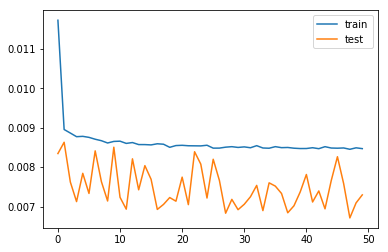

Test RMSE: 5.221


In [25]:
model.add(LSTM(70,  dropout=0.2, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1, activation='relu'))

model.compile(loss='mae', optimizer='adam')
history = model.fit(train_X, train_y, epochs=50, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)